## Notebook for evaluation of a trained AutoEncoder Model
- This notebook is step 1 of 3 in setting up a model pipeline for generating particle decay event images
- The notebook is broken up into the following components:
    - Loss evaluation and plotting
        - The loss for the entire training cycle is plotted
        - The loss curves for each of the model checkpoints between 600 and 1000 are plotted
            - We compute the average loss value over 10k test samples and 10k training samples
    - An appropriately generalizable Decoder is chosen based on the smalled difference in MSE value from the previous evaluation step
    - Sets of sample images are generated for that checkpoint using test data in order to assess image reconstruction quality
    - A set of code vector targets is generated using that model checkpoint

## Import Libraries

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Import Files from full path on Meitner Machine

In [2]:
import sys
sys.path.insert(1, '/home/kseuro/Kai/deeplearnphysics/pytorch/particle_generator/')

# Meitner Machine
import ae
import conv_ae
import utils
from dataloader import LArCV_loader

#### Set the GPU to be used for model evaluation
- On Meitner, GPU 1 is the best option

In [3]:
device = torch.device(1)

#### Set the root path of the AutoEncoder Experiments Folder

In [4]:
exp_root = "/media/hdd1/kai/particle_generator/experiments/"

#### Select the model class and append to the experiment root

In [5]:
model_class = {'mlp': 'mlp_ae/', 'conv':'conv_ae/'}

In [6]:
model_folder = "larcv_ae/" + model_class['conv']

In [7]:
exp_root += model_folder

### Find all the experiments in the exp_root folder

In [8]:
exp_paths = []
for path in os.listdir(exp_root):
    exp_paths.append(os.path.join(exp_root, path))

In [9]:
print("-"*60)
for i in range(len(exp_paths)):
    exp_name = exp_paths[i].split('/')[-1]
    print("\n{}:".format(str(i)), exp_name, '\n')
    print("-"*60)

------------------------------------------------------------

0: conv_ae_128_4-4-4 

------------------------------------------------------------

1: conv_ae_128_20-4-4 

------------------------------------------------------------

2: conv_ae_64_12-4-4 

------------------------------------------------------------

3: conv_ae_64_4-4-4 

------------------------------------------------------------

4: conv_ae_64_1000-epochs 

------------------------------------------------------------

5: conv_ae_128_32-8-8-code-dim 

------------------------------------------------------------

6: conv_ae_256_102-4-4 

------------------------------------------------------------


### Choose the experiment for evaluation

In [10]:
exp_dir = exp_paths[2]

In [11]:
# Create the full path to the experiment
exp_path = os.path.join(exp_root, exp_dir) + "/"
print("Experiment path set as: \n{}".format(exp_path))

Experiment path set as: 
/media/hdd1/kai/particle_generator/experiments/larcv_ae/conv_ae/conv_ae_64_12-4-4/


In [12]:
# Set path from where to load the model weights
weights_dir = "weights/"

### Load the model configuration information from the config.csv

In [13]:
# Load the config csv as a dict
config_csv = exp_path + "config.csv"
config_df = pd.read_csv(config_csv, delimiter = ",")

In [40]:
# Get the model architecture from config df
num_epochs = int(config_df[config_df['Unnamed: 0'].str.contains("epochs")==True]['0'].values.item())
n_layers = int(config_df[config_df['Unnamed: 0'].str.contains("n_layers")==True]['0'].values.item())
l_dim    = int(config_df[config_df['Unnamed: 0'].str.contains("l_dim")==True]['0'].values.item())
depth    = int(config_df[config_df['Unnamed: 0'].str.contains("depth")==True]['0'].values.item())
im_size  = int(config_df[config_df['Unnamed: 0'].str.contains("dataset")==True]['0'].values.item())**2
im_dim   = int(np.sqrt(im_size))

### Compute the layer dimensions for the AutoEncoder
- TODO: Need to add function that deals with an AutoEncoder Model trained on MNIST

In [15]:
# Set up AE layer sizes
if 'mlp' in exp_path:    
    base = [256] 

    # Compute encoder sizes
    sizes = lambda: [ (yield 2**i) for i in range(n_layers) ]
    enc_sizes = base * n_layers
    enc_sizes = [a*b for a,b in zip(enc_sizes, [*sizes()])][::-1]

    # Update kwarg dicts
    # Decoder is the reverse of the encoder
    ae_kwargs = {'enc_sizes' : enc_sizes, 'l_dim' : l_dim, 'im_size' : im_size, 'dec_sizes' : enc_sizes[::-1]}
else:
    # Compute the depth of the feature maps, based on the number of
    # specified layers. If depth is not divisibe by 4, warn
    depth   = [depth] * n_layers
    divisor = lambda: [ (yield 2**i) for i in range(n_layers) ]
    depth   = [a//b for a,b in zip(depth, [*divisor()])][::-1]
        
    # Update kwarg dicts
    # Decoder is the reverse of the encoder
    ae_kwargs = {'enc_depth':[1] + depth, 'dec_depth':depth[1:len(depth)][::-1] + [1],'l_dim':l_dim}

In [16]:
print("Model l_dim: {}".format(l_dim))
print("Encoder depth: {}".format(ae_kwargs['enc_depth']))
print("Decoder depth: {}".format(ae_kwargs['dec_depth']))

Model l_dim: 12
Encoder depth: [1, 4, 8, 16, 32]
Decoder depth: [32, 16, 8, 1]


### Setup Model loss function

In [17]:
loss_fn = nn.MSELoss().to(device)

### Set up tracking of MSE evaluation results

In [27]:
MSE_results = []

## Load Model from Checkpoint

### Get the list of checkpoint files

In [18]:
checkpoint_path  = exp_path + weights_dir
checkpoint_names = []
for file in os.listdir(checkpoint_path):
    checkpoint_names.append(os.path.join(checkpoint_path, file))

In [19]:
# We wish to save a list of labels for ease of plot labelling later
checkpoint_name_labels = []

In [20]:
print("-"*60)
for i in range(len(checkpoint_names)):
    name = checkpoint_names[i].split('/')[-1]
    checkpoint_name_labels.append(name)
    print("\n{}:".format(str(i)), name, '\n')
    print("-"*60)

------------------------------------------------------------

0: best_conv_ae_ep_650.tar 

------------------------------------------------------------

1: best_conv_ae_ep_600.tar 

------------------------------------------------------------

2: best_conv_ae_ep_999.tar 

------------------------------------------------------------

3: best_conv_ae_ep_700.tar 

------------------------------------------------------------

4: best_conv_ae_ep_850.tar 

------------------------------------------------------------

5: best_conv_ae_ep_900.tar 

------------------------------------------------------------

6: best_conv_ae_ep_950.tar 

------------------------------------------------------------

7: best_conv_ae_ep_750.tar 

------------------------------------------------------------

8: best_conv_ae_ep_800.tar 

------------------------------------------------------------


### Select the checkpoint you wish to evaluate

In [21]:
index = 1
current_checkpoint = checkpoint_names[index]
current_checkpoint_label = checkpoint_name_labels[index]

### Load the checkpoint file using PyTorch

In [22]:
# Load the model checkpoint
# Keys: ['state_dict', 'epoch', 'optimizer']
checkpoint = torch.load(current_checkpoint)

### Set up the model on the GPU

In [23]:
# Set up model on GPU
if 'mlp' in exp_path:
    model = ae.AutoEncoder(**ae_kwargs).to(device)
else:
    model = conv_ae.ConvAutoEncoder(**ae_kwargs).to(device)

### Load the model's state dictionary

In [24]:
# Load the model's state dictionary
# Note: The IncompatibleKeys(missing_keys=[], unexpected_keys=[]) message indicates that
#       there were no problems in loading the state dictionary. Bit confusing...
model.load_state_dict(checkpoint['state_dict'], strict=False)

<All keys matched successfully>

### Put model in training mode

In [25]:
model.eval()

ConvAutoEncoder(
  (encoder): ConvEncoder(
    (conv_blocks): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (3): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

## Setup the PyTorch Dataloader

### Set the paths to the test data and reference training dataset

#### Test Data

In [29]:
test_data = "/media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_{}/".format(im_dim)
num_test_ex = sum( [len(examples) for _, _, examples in os.walk(test_data)] )
print("{} test data will be loaded from: \n{}".format(num_test_ex, test_data))

10000 test data will be loaded from: 
/media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_64/


#### Reference Training Data

In [30]:
train_data = "/media/hdd1/kai/particle_generator/larcv_data/train/train_reference/larcv_png_{}/".format(im_dim)
num_train_ex = sum( [len(examples) for _, _, examples in os.walk(train_data)] )
print("{} reference training data will be loaded from: \n{}".format(num_train_ex, train_data))

10000 reference training data will be loaded from: 
/media/hdd1/kai/particle_generator/larcv_data/train/train_reference/larcv_png_64/


#### Setup two instances of a dataloader object

In [34]:
loader_kwargs = {'num_workers' : 2, 'batch_size': 1, 'shuffle': True}

In [35]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])

AttributeError: 'Compose' object has no attribute 'Compose'

In [36]:
test_dataset    = LArCV_loader(root = test_data,  transforms = transforms)

Image conversion flag is: L
Images will be loaded from subfolder of: /media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_64/


In [37]:
test_loader = DataLoader(test_dataset, **loader_kwargs)

In [33]:
train_dataset   = LArCV_loader(root = train_data, transforms = transforms)

Image conversion flag is: L
Images will be loaded from subfolder of: /media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_64/
Image conversion flag is: L
Images will be loaded from subfolder of: /media/hdd1/kai/particle_generator/larcv_data/train/train_reference/larcv_png_64/


In [38]:
train_loader = DataLoader(train_dataset, **loader_kwargs)

## Get Model Loss Curves

### Full loss curve for entire training cycle

In [39]:
losses_csv = exp_path + "losses.csv"
losses_df = pd.read_csv(losses_csv, delimiter = ",")
losses = np.asarray(losses_df['ae_loss'])

In [53]:
# Compute average loss per epoch based based on loss array len
step = int(len(losses) / num_epochs)
new_losses = []
for i in range(0, len(losses), step):
    new_losses.append( sum(losses[i:i+step]) / step )
new_losses = np.asarray(new_losses)

In [43]:
# Compute the plot title
if 'mlp' in exp_path:
    title = "MLP AutoEncoder Training Loss" 
else:
    title = "Convolutional AutoEncoder Training Loss"

In [44]:
# Compute the experiment label
if 'mlp' in exp_path:
    label = "{}x{} Dataset | {} Dimensional Code Vector".format(im_dim, im_dim, l_dim)
else:
    label = "{}x{} Dataset | {}x{}x{} Dimensional Code Volume".format(im_dim, im_dim, l_dim, 4, 4)

In [51]:
# Compute the file name for saving
if 'mlp' in exp_path:
    save_file = "training_loss_MLP_AE_{}_dataset_{}_l-dim.png".format(im_dim, l_dim)
else:
    save_file = "training_loss_Conv_AE_{}_dataset_{}-{}-{}_code-volume.png".format(im_dim, l_dim, 4, 4)

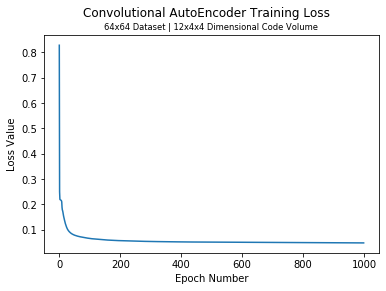

In [56]:
%matplotlib inline
# Plot the losses against the number of epochs
fig, axes = plt.subplots(1,1)
fig.suptitle(title)

axes.set_title(label, fontsize="small")
axes.set_xlabel("Epoch Number")
axes.set_ylabel("Loss Value")

# Plot data
axes.plot(np.arange(0, num_epochs), new_losses)

# Generate and save image
plt.savefig(save_file, dpi=300)